In [3]:
import torch
from torchvision import datasets, transforms
import numpy as np
import pickle
import matplotlib.pyplot as plt
import random
import torch.optim as optim
import torch.utils.data
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch.optim.lr_scheduler import LambdaLR, ExponentialLR, StepLR, CosineAnnealingLR
from torch.optim import AdamW
from models import *
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ExponentialLR
import time 


# Load CIFAR 10 Data


In [4]:
# Function to load a batch file and return a dictionary
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Load dataset, combine batches, split, and visualize images
def load_and_prepare_data():
    # Load and combine the training batches
    data_batches, label_batches = [], []
    for i in range(1, 6):
        batch = unpickle(f'data/KaggleData/cifar-10-python/cifar-10-batches-py/data_batch_{i}')
        data_batches.append(batch[b'data'])
        label_batches.append(batch[b'labels'])
    X, y = np.concatenate(data_batches), np.concatenate(label_batches)
    
    # Split into training and validation sets (80-20 split)
    return train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = load_and_prepare_data()

# Define transformations
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
transformations = {
    'train': transforms.Compose([
        transforms.RandomCrop(32, padding=4, padding_mode='reflect'), 
        transforms.RandomHorizontalFlip(), 
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(), 
        transforms.RandomApply([transforms.RandomErasing()], p=0.5),
        transforms.Normalize(*stats)]),
        
    'valid': transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize(*stats)]),
        
    # Normalization only for 'train_Default' scenario
    'normalization_only': transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize(*stats)])
}

# Adjusting the CIFAR10Dataset class initialization to accept 'data_mode'
class CIFAR10Dataset(Dataset):
    def __init__(self, data, labels, transform=None, data_mode='default'):
        self.data = data
        self.labels = labels
        self.transform = transform
        self.data_mode = data_mode
        if data_mode == 'train_Enhanced':
            self.data = np.concatenate((self.data, self.data), axis=0)
            self.labels = np.concatenate((self.labels, self.labels), axis=0)
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        if self.data_mode == 'train_Enhanced' and idx >= len(self.labels) // 2:
            transform = transformations['train']
        else:
            transform = self.transform
        image = self.data[idx % len(self.labels)].reshape(3, 32, 32).transpose(1, 2, 0)
        image = Image.fromarray(image.astype('uint8'), 'RGB')
        image = transform(image)
        return image, self.labels[idx % len(self.labels)]

# Create datasets and DataLoader instances
datasets = {
    'train_Enhanced': CIFAR10Dataset(X_train, y_train, transform=transformations['normalization_only'], data_mode='train_Enhanced'),
    'valid': CIFAR10Dataset(X_val, y_val, transform=transformations['valid'])
}

# Update loaders for each dataset
loaders = {
    'train_Enhanced': DataLoader(datasets['train_Enhanced'], batch_size=64, shuffle=True,num_workers=0),
    'valid': DataLoader(datasets['valid'], batch_size=64, shuffle=False,num_workers=0)
}

print('Amount of Train Data batches (Enhanced):', len(loaders['train_Enhanced']))
print('Amount of Valid Data batches:', len(loaders['valid']))

print('Amount of training images (Enhanced):', len(datasets['train_Enhanced']))
print('Amount of Validation images:', len(X_val))


Amount of Train Data batches (Enhanced): 1250
Amount of Valid Data batches: 157
Amount of training images (Enhanced): 80000
Amount of Validation images: 10000


In [5]:
# first_batch_images, first_batch_labels = next(iter(loaders['train_Enhanced']))
# print(f"First batch images shape: {first_batch_images.shape}")
# print(f"First batch labels shape: {first_batch_labels.shape}")


In [6]:
# #visualize:
# import matplotlib.pyplot as plt
# import numpy as np
# from torchvision.transforms import ToPILImage
# from random import sample

# # Define a function to show images in a grid
# def show_images(images, labels, classes, rows=2, cols=5, scale=2):
#     fig, axes = plt.subplots(rows, cols, figsize=(scale*cols, scale*rows))
#     axes = axes.flatten()
#     for img, label, ax in zip(images, labels, axes):
#         img = img.reshape(3, 32, 32).transpose(1, 2, 0)  # Convert to HxWxC format
#         if np.max(img) > 1:  # Assume the image is in the range [0, 255]
#             img = img / 255.0
#         ax.imshow(img)
#         ax.axis('off')
#         ax.set_title(classes[label])
#     plt.tight_layout()
#     plt.show()

# # Classes in CIFAR-10
# classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
#            'dog', 'frog', 'horse', 'ship', 'truck']

# # Randomly select 10 images and their labels from training set
# indices_train = sample(range(len(X_train)), 10)
# images_train = X_train[indices_train]
# labels_train = y_train[indices_train]

# # Randomly select 10 images and their labels from validation set
# indices_val = sample(range(len(X_val)), 10)
# images_val = X_val[indices_val]
# labels_val = y_val[indices_val]

# # Display training images
# print("Training Images:")
# show_images(images_train, labels_train, classes)

# # Display validation images
# print("Validation Images:")
# show_images(images_val, labels_val, classes)



# Model finetuning

### 1st  Test: Architecture Test:

- Test number of Layers (4 Training Runs): 

     train with 2,3,4,5 layers [same amount of blocks for all layers [2,2,2,2], Similar amount of Conv-featuremaps for each layer [2layers: 64,256],[3 Layers: 64,128,256],[4Layers: 64,128,128,256]], [5 Layers: 64,64,128,128,256] 

- Test best Config of Blocks per Layer (4 Training Runs):

     Suppose the prev. test returned that 4 layers gives best valid accuracy: Run through training with 4 permutations of Blocks Per Layers (only choose either 3 or 2 blocks per layer to keep it simple) 

Goal: Figure out best Architecture by finding optimal Amount of Layers, and optimal Amount of Blocks per Layer.

Guidelines for Architecture Test: No Dropouts, and no Data Augmentation (but normalization)

### 2nd Test: Training Parameter Gridsearch

2nd Test: Hyperparameter Gridsearch:
- Learning Rate (4 tests)

     LR set to [0.1, 0.01, 0.001, 0.0001] (while using ADAM as Optimizer, no LR scheduler)

- Optimizer: (4 tests)
     
     Having figured out best LR, test different Optimizers: SGD, ADAM, ADAMW(0.01) (3 Training Runs)
     if ADAMW returns best Valid Acc. figure out which weight decay to use [0.1,0.01,0.001,0.0001] 

- Exponential scheduler or not (2 differenttests. Exponential LR with gamma 0.98)

Goal: Figure out best set of training-setup

### 3rd Test: Data ingestion Method: 
- Batchsize [ 32, ,64, 128, 256] (4 tests)
- Augmentation (Random Flipping, cropping) (3 Tests)

     1. No Augmentation applied, 
     2. With Random Flipping and Cropping, 
     3. With Random and Cropping but copying the Altered images on top of the original training data (increase training images from 40k to 80k)     
     



In [7]:
def Resnet3_443Exp():
    return ResNet3(BasicBlock, [4,4,3])

model = Resnet3_443Exp()

total_paramsResnet3_443 = sum(p.numel() for p in model.parameters())
print(f"Total parameters modelResnet3_443: {total_paramsResnet3_443}")

# Move the model to CUDA device if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(0))

model.to(device)

Total parameters modelResnet3_443: 4697162
NVIDIA GeForce RTX 4070


ResNet3(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine

# Training

In [8]:


def train_and_evaluate_model(model, model_name, loaders, device, num_epochs=1):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.0001)
    scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

    train_loss_history, valid_loss_history, valid_accuracy_history, train_accuracy_history = [], [], [], []
    best_accuracy = 0.0
    start_time = time.time()

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss, total_train_loss, total_correct_train, num_batches, num_train_examples = 0.0, 0.0, 0, 0, 0
        for i, (inputs, labels) in enumerate(loaders["train_Enhanced"]):
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.long()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(),0.1)
            optimizer.step()

            running_loss += loss.item()
            total_train_loss += loss.item() * inputs.size(0)
            num_batches += 1

            _, predicted = torch.max(outputs.data, 1)
            total_correct_train += (predicted == labels).sum().item()
            num_train_examples += labels.size(0)

            if (i + 1) % 100 == 0 or i == len(loaders["train_Enhanced"]) - 1:
                print(f"{model_name}, train_Enhanced - Epoch: {epoch} [{(i + 1) * len(inputs)}/{len(loaders['train_Enhanced'].dataset)} "
                      f"({100. * (i + 1) / len(loaders['train_Enhanced']):.0f}%)], Weight Decay: 0.0001,  Loss: {running_loss / num_batches:.4f}")

        avg_train_loss = total_train_loss / num_train_examples  # Correct average training loss calculation
        train_loss_history.append(avg_train_loss)

        train_accuracy = 100. * total_correct_train / num_train_examples
        train_accuracy_history.append(train_accuracy)

        model.eval()
        total_valid_loss, total_correct_valid, num_valid_batches = 0.0, 0, 0
        for inputs, labels in loaders['valid']:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.long()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_valid_loss += loss.item() * inputs.size(0)  # Update to multiply by batch size for total loss
            _, predicted = torch.max(outputs.data, 1)
            total_correct_valid += (predicted == labels).sum().item()
            num_valid_batches += 1

        avg_valid_loss = total_valid_loss / len(loaders['valid'].dataset)  # Correct average validation loss calculation
        valid_loss_history.append(avg_valid_loss)

        valid_accuracy = 100. * total_correct_valid / len(loaders['valid'].dataset)
        valid_accuracy_history.append(valid_accuracy)

        print(f"End of Epoch: {epoch}, Avg. Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Avg. Valid Loss: {avg_valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.2f}%")

        if valid_accuracy > best_accuracy:
            best_accuracy = valid_accuracy
            model_path = f'{model_name}_Final_best_model.pth'
            torch.save(model.state_dict(), model_path)
            print(f"New best model saved: {model_path}")

        scheduler.step()

    execution_time = time.time() - start_time
    print(f"Training completed. Total execution time: {execution_time:.2f} seconds")

    return train_loss_history, valid_loss_history, valid_accuracy_history, train_accuracy_history


In [9]:


# Assuming Resnet3_443 is defined and device is set
# model = Resnet3_443().to(device)
num_epochs = 200  # Or any other number of epochs you want to train for

all_metrics_final = {
    'train_losses': [],
    'valid_losses': [],
    'valid_accuracies': [],
    'train_accuracies': []
}

def ResNet3_with_dropout_30DR():
    return ResNet3Dropouts(BasicBlockDropouts, [4, 4, 3], dropout_rate=0.3)  # For example, a dropout rate of 0.5

modelResnet3_443_30DR = ResNet3_with_dropout_30DR()
total_paramsResnet3_443_30DR = sum(p.numel() for p in modelResnet3_443_30DR.parameters())
print(f"Total parameters modelResnet3_443_30DR: {total_paramsResnet3_443_30DR}")

# Re-initialize the model for each weight decay to ensure training starts fresh
model = ResNet3_with_dropout_30DR().to(device)
metrics = train_and_evaluate_model(model, "modelResnet3_443_30DR", loaders, device, num_epochs)


# Unpack and store the returned metrics
all_metrics_final['train_losses'], \
all_metrics_final['valid_losses'], \
all_metrics_final['valid_accuracies'], \
all_metrics_final['train_accuracies'] = metrics


plt.figure(figsize=(20, 10))

# Training Loss
plt.subplot(2, 2, 1)
plt.plot(all_metrics_final['train_losses'], label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Validation Loss
plt.subplot(2, 2, 2)
plt.plot(all_metrics_final['valid_losses'], label='Validation Loss')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Validation Accuracy
plt.subplot(2, 2, 3)
plt.plot(all_metrics_final['valid_accuracies'], label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# Training Accuracy
plt.subplot(2, 2, 4)
plt.plot(all_metrics_final['train_accuracies'], label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


Total parameters modelResnet3_443_30DR: 4697162
modelResnet3_443_30DR, train_Enhanced - Epoch: 1 [6400/80000 (8%)], Weight Decay: 0.0001,  Loss: 2.0818
modelResnet3_443_30DR, train_Enhanced - Epoch: 1 [12800/80000 (16%)], Weight Decay: 0.0001,  Loss: 1.9390
modelResnet3_443_30DR, train_Enhanced - Epoch: 1 [19200/80000 (24%)], Weight Decay: 0.0001,  Loss: 1.8458
modelResnet3_443_30DR, train_Enhanced - Epoch: 1 [25600/80000 (32%)], Weight Decay: 0.0001,  Loss: 1.7741
modelResnet3_443_30DR, train_Enhanced - Epoch: 1 [32000/80000 (40%)], Weight Decay: 0.0001,  Loss: 1.7189
modelResnet3_443_30DR, train_Enhanced - Epoch: 1 [38400/80000 (48%)], Weight Decay: 0.0001,  Loss: 1.6697
modelResnet3_443_30DR, train_Enhanced - Epoch: 1 [44800/80000 (56%)], Weight Decay: 0.0001,  Loss: 1.6291
modelResnet3_443_30DR, train_Enhanced - Epoch: 1 [51200/80000 (64%)], Weight Decay: 0.0001,  Loss: 1.5897
modelResnet3_443_30DR, train_Enhanced - Epoch: 1 [57600/80000 (72%)], Weight Decay: 0.0001,  Loss: 1.5560


KeyboardInterrupt: 

In [ ]:
# Load best Model
model_path = 'Resnet3_443_Exp_Final_best_model.pth'
model.load_state_dict(torch.load(model_path))
model.eval()


ResNet3(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine

# Testing

test images:


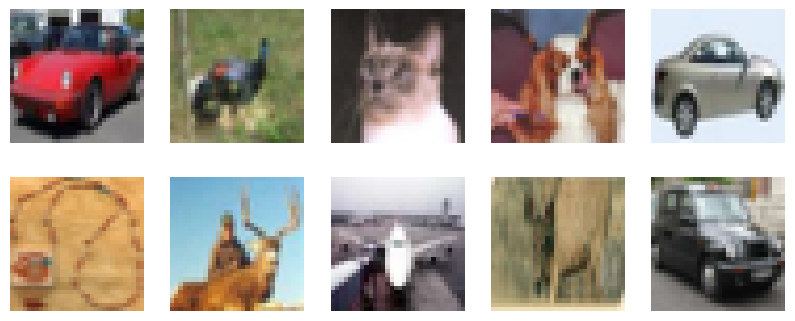

In [ ]:

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

test_data_dict = unpickle('./data/cifar_test_nolabels.pkl')
test_images = test_data_dict[b'data']
test_images = test_images.reshape(-1, 3, 32, 32)

# Modified function to show random images
def show_original_random_images(images, rows=2, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    indices = np.random.choice(len(images), rows*cols, replace=False)  # Select random indices
    for i, ax in enumerate(axes.flat):
        # Use the random index to select an image
        img = images[indices[i]].transpose(1, 2, 0)
        ax.imshow(img.astype('uint8'))
        ax.axis('off')
    plt.show()

print('test images:')
# Show 10 random original images
show_original_random_images(test_images, rows=2, cols=5)


In [ ]:
model_path

'Resnet3_443_Exp_Final_best_model.pth'

In [ ]:
#Load Best Model, Normalize test data, do an inference and create submission csv file

# Convert test_images to a float tensor
test_images = torch.from_numpy(test_images).float()

# If the pixel values are in [0,255], scale them to [0,1]
if test_images.max() > 1.0:
    test_images /= 255.0

# Permute the images to [N, C, H, W] format
test_images = test_images.permute(0, 1, 2, 3)


# Define the normalization transform
normalize = transforms.Normalize(*stats) #takes mean and std from loadingand transforming the validation data

# Normalize the images
normalized_images = torch.stack([normalize(img) for img in test_images])

# Make sure your model is on the right device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#load best model.pth
# model.load_state_dict(torch.load('best_model.pth'))
# Load the model state dict into the model



model.load_state_dict(torch.load(model_path))


model.to(device)

# Now, ensure your input data is also sent to the same device
normalized_images = normalized_images.to(device)

model.eval()  # Set the model to evaluation mode

predictions = []
with torch.no_grad():  # No need to track gradients
    for img in normalized_images:
        img = img.unsqueeze(0).to(device)  # Add batch dimension and ensure the tensor is on the right device
        output = model(img)  # Process each image individually
        pred = output.argmax(dim=1)  # Get the index of the max log-probability
        predictions.append(pred.item())
print(len(predictions))

# Create a DataFrame with the ID and predicted Labels
submission_df = pd.DataFrame({
    'ID': list(range(len(predictions))),
    'Labels': predictions
})

# Define the submission CSV file path
submission_csv_path = 'submission.csv'
# Save the DataFrame to a CSV file, without the index
submission_df.to_csv(submission_csv_path, index=False)

# Returning the path to the saved CSV file
submission_csv_path

10000


'submission.csv'